# Lab:  Nonlinear Least Squares for Modeling Materials - pa2191

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

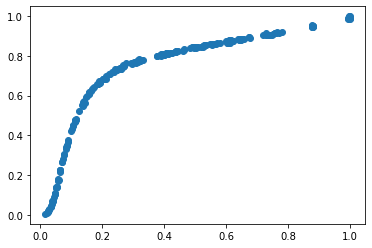

In [3]:
# TODO
# x0 = ...
# y0 = ...
# x = x0/np.max(x0)
# y = y0/np.max(y0)
# plt.plot(...)
x0=np.array(df['x0'])
y0=np.array(df['y0'])
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.plot(x,y,'o')

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.02 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

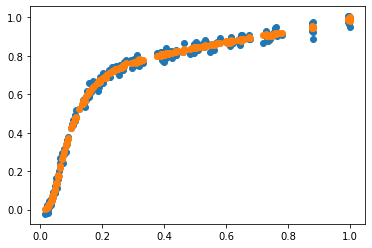

In [4]:
# TODO
# yn = y + ...
n = len(y0)
yn = y + np.random.normal(0,0.02,n)

plt.plot(x,yn,'o')
plt.plot(x,y,'o')

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO
# xtr, xts, ytr, yts = ...
xtr, xts, ytr, yts = train_test_split(x,yn,test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [6]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO 4.  Extract a and b from w
    a = w[:d+1]
    b = w[d+1:]
    # TODO 5.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    yhat = np.polyval(a[::-1],x)/np.polyval(b[::-1]+[1],x)
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [7]:
d = 3

# TODO 6.  Create the transformed feature matrix

Z = np.column_stack((np.power(xtr[:,None],np.arange(1,d+1)),ytr[:,None]*np.power(xtr[:,None],np.arange(1,d+1))))

# TODO 7.  Fit with parameters with linear regression

regr = LinearRegression()
regr.fit(Z,ytr)

# TODO 8
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit

winit = np.concatenate((regr.intercept_,regr.coef_),axis=None)

Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

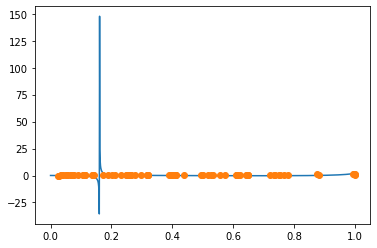

In [8]:
# TODO
# xp = ...
# yhat = ...
# plot(...)

xp = np.linspace(0,1,1000)
yhat = predict(winit,xp)
plt.plot(xp,yhat)
plt.plot(xts,yts,'o')

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

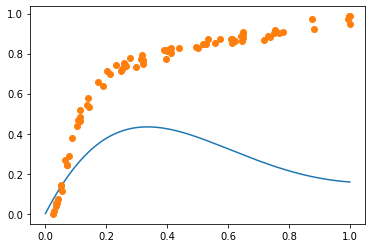

In [9]:
# TODO.  Fit with parameters with linear regression
# regr = Ridge(alpha=1e-3)
# regr.fit(...)

regr = Ridge(alpha=1e-3)
regr.fit(Z,ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
# winit = ...

w0 = regr.coef_
a0 = regr.intercept_

winit = np.hstack((a0,w0))

# TODO
# Plot the results as above.
xp = np.linspace(0,1,1000)
yhat = predict(winit,xp)
plt.plot(xp,yhat)
plt.plot(xts,yts,'o')

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [10]:
def feval(w,x,y):
    
    d = (len(w)-1)//2
    # TODO 13.  Parse w
    a = w[:d+1]
    b = w[d+1:]

    # TODO 14.  Znum[i,j] = x[i]**j
    Znum = np.power(x[:,None],np.arange(0,d+1))
    # TODO 15.  Zden[i,j] = x[i]**(j+1)
    Zden = np.power(x[:,None],1+np.arange(0,d))
    # TODO 16.  Compute yhat 
    # Compute the numerator and denominator
    yhat_num = np.sum(Znum.dot(a))
    yhat_den = 1+np.sum(Zden.dot(b))
    yhat = yhat_num/yhat_den
    
    # TODO 17.  Compute loss
    f = 0.5*np.sum((y-yhat)**2)
    
    # TODO 18.  Compute gradients
    # To compute the gradient we will
    df_dy = -np.sum(y-yhat)
    dy_da = np.sum(Znum,axis=0)/yhat_den
    dy_db = -np.sum(Zden,axis=0)*yhat_num/(yhat_den**2)
    
    fgrad = np.hstack((df_dy*dy_da,df_dy*dy_db))
    return f, fgrad



Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [11]:
# TODO 19
w0 = winit
# using a lambda function method
feval_param = lambda w: feval(w,xtr,ytr)
f0,fgrad0 = feval_param(w0)
print(fgrad0.shape)
# perturbing the w_init by some small step
step = 1e-6
w1 = w0 + step*np.random.randn(w0.shape[0])
# Measure the function and gradient at w0 and w1
f1, fgrad1 = feval_param(w1)
# Predict the amount the function should have changed based on the gradient
df_est = np.sum(fgrad0.dot(w1-w0))
# Print the two values to see if they are close
print("Actual f1-f0    = %12.4e" % (f1-f0))
print("Predicted f1-f0 = %12.4e" % df_est)

(7,)
Actual f1-f0    =  -4.1236e-04
Predicted f1-f0 =  -4.1236e-04


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

Text(0, 0.5, 'loss / objective function')

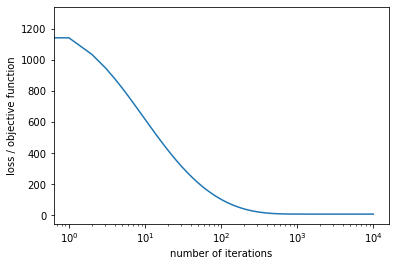

In [12]:
# TODO 20
# fgd = ...
nit = 10000
step = 1e-6
def grad_opt_simp(feval_param, winit=winit, lr=step,nit=nit):
    # Initialize
    w0 = winit
    fgd = []
    # Loop over iterations
    for it in range(nit):
        # Evaluate the function and gradient
        f0, fgrad0 = feval_param(w0)
        # Take a gradient step
        w0 = w0 - lr*fgrad0
         # Save history
        fgd.append(f0)
    # Convert to numpy arrays
    return w0, f0, fgd
w,f,fgd = grad_opt_simp(feval_param)

plt.semilogx(np.arange(nit),fgd)
plt.xlabel("number of iterations")
plt.ylabel("loss / objective function")

Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

Text(0, 0.5, 'loss / objective function')

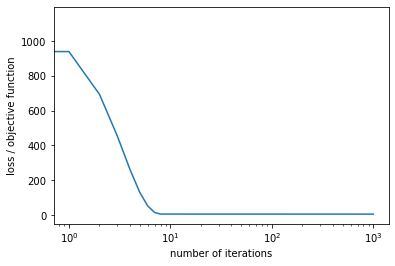

In [13]:
# TODO 21

nit = 1000
step = 1e-6  # Initial step
def grad_opt_adapt(feval_param, winit=winit, nit=nit, lr_init=step):
    # Set initial point
    w0 = winit
    f0, fgrad0 = feval_param(w0)
    lr = lr_init
    fadapt = []
    for it in range(nit):
        w1 = w0 - lr*fgrad0
        f1, fgrad1 = feval_param(w1)
        df_est = fgrad0.dot(w1-w0)
        # Check if test point passes the Armijo condition
        alpha = 0.5
        if (f1-f0 < alpha*df_est) and (f1 < f0):
            # If descent is sufficient, accept the point and increase the
            # learning rate
            lr = lr*2
            f0 = f1
            fgrad0 = fgrad1
            w0 = w1
        else:
            lr = lr/2            
        fadapt.append(f0)
    return w0, f0, fadapt
w,f,fadapt = grad_opt_adapt(feval_param)

plt.semilogx(np.arange(nit),fadapt)
plt.xlabel("number of iterations")
plt.ylabel("loss / objective function")

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

Text(0, 0.5, 'y values')

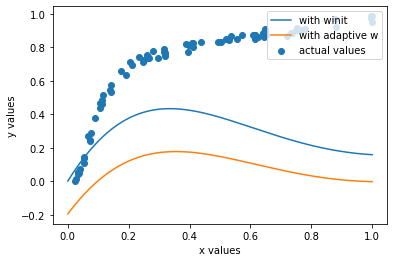

In [14]:
# TODO 22
xp = np.linspace(0,1,1000)
yhat_old = predict(winit,xp)
yhat_new = predict(w,xp)
plt.plot(xp,yhat_old)
plt.plot(xp,yhat_new)
plt.scatter(xts,yts)
plt.legend(["with winit","with adaptive w","actual values"], loc='upper right')
plt.xlabel("x values")
plt.ylabel("y values")

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-3`.   Compare the convergence of the loss function with gradient descent.  

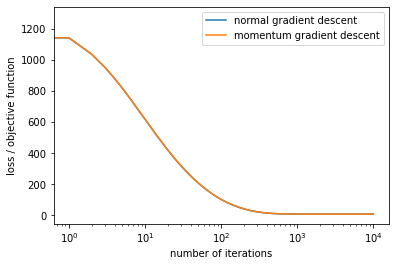

In [15]:
# TODO 23
nit = 1000
step = 1e-3
beta = 0.99
def grad_opt_mom(feval_param, winit=winit, nit=nit, lr=step,beta=beta):
    # Initialize
    w0 = winit
    f_mom = []
    # Loop over iterations
    for it in range(nit):
        # Evaluate the function and gradient
        f0, fgrad0 = feval_param(w0)
        z= beta*z + fgrad0
        # Take a gradient step
        w0 = w0 - lr*z
         # Save history
        f_mom.append(f0)
    # Convert to numpy arrays
    return w0, f0, f_mom
w,f,f_mom = grad_opt_simp(feval_param)

plt.semilogx(np.arange(nit*10),fgd)
plt.semilogx(np.arange(nit*10),f_mom)
plt.xlabel("number of iterations")
plt.ylabel("loss / objective function")
plt.legend(["normal gradient descent","momentum gradient descent"], loc='upper right')

Text(0, 0.5, 'y values')

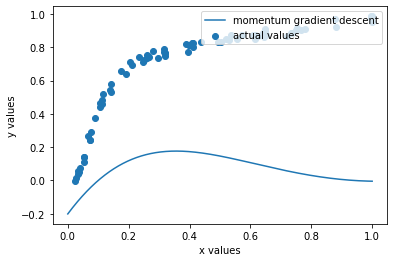

In [16]:
# TODO 24
# plot yhat vs. x
xp = np.linspace(0,1,1000)
yhat = predict(w,xp)
plt.plot(xp,yhat)
plt.scatter(xts,yts)
plt.legend(["momentum gradient descent","actual values"], loc='upper right')
plt.xlabel("x values")
plt.ylabel("y values")

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.